# Import libraries

In [1]:
import sklearn
sklearn.__version__

'0.24.2'

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats
import math
import pickle
from sklearn.utils import resample
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

# Train-Test
from sklearn.model_selection import train_test_split


# Scaler
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Normalization
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Classification models
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

## Outliers

In [3]:
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary
    
def transform_outliers(df, norm_col, threshold_capped=1.5, threshold_trimmed=1.8,  test_mode=False, limits={},
                        use_manual_limits=False, upper_limit_trim=0, lower_limit_trim=0, upper_limit_cap=0, lower_limit_cap=0, print_output=False):
    
    outliers_limits={}
    # Trimming and capping outliers
    outliers_total = np.array(np.repeat(False,df.shape[0]))
    df_capped = df.copy()
    for col in norm_col:
        
        if not test_mode:
            outliers_limits_col={}
            if use_manual_limits:
                upper_limit, lower_limit = upper_limit_trim, lower_limit_trim
            else:
                upper_limit, lower_limit = find_skewed_boundaries(df, col, threshold_trimmed)

            outliers_limits_col['upper_limit_trim'] = upper_limit
            outliers_limits_col['lower_limit_trim'] = lower_limit
        else:
            upper_limit, lower_limit = limits[col]['upper_limit_trim'], limits[col]['lower_limit_trim']

        outliers = np.where(df[col] > upper_limit, True,
                            np.where(df[col] < lower_limit, True, False))                        
        outliers_total = np.logical_or(outliers_total, outliers)
        
        if print_output:
            print(str(col) + " outliers = "+str(outliers.sum()))
        
        if not test_mode:
            if use_manual_limits:
                upper_limit, lower_limit = upper_limit_cap, lower_limit_cap
            else:
                upper_limit, lower_limit = find_skewed_boundaries(df, col, threshold_capped)

            outliers_limits_col['upper_limit_cap'] = upper_limit
            outliers_limits_col['lower_limit_cap'] = lower_limit
            outliers_limits[col] = outliers_limits_col
        else:
            upper_limit, lower_limit = limits[col]['upper_limit_cap'], limits[col]['lower_limit_cap']

        df_capped[col] = np.where(df[col] > upper_limit, upper_limit,
                            np.where(df[col] < lower_limit, lower_limit, df_capped[col]))

    if print_output:
        print("Total outliers = "+str(outliers_total.sum()))
        
    df_trimmed = df_capped.loc[~(outliers_total)]
    
    if not test_mode:
        return df_trimmed, outliers_limits
    else:
        return df_trimmed

## Simple median imputation

In [4]:
def median_imputer(df,cols,test_mode=False,imputer_trained=None):
    df_imputed = df.copy()

            
    if not test_mode:
        imputer = SimpleImputer(strategy='median',add_indicator=True) # Create imputer
    else:
        imputer = imputer_trained

    X_imputed_median = imputer.fit_transform(df_imputed[cols]) # Fit-transform
    imputed_median_cols = [str(d) + "_imputed" for d in cols]  # Name of indicators of imputation
    median_cols = cols + imputed_median_cols

    assert(not np.isnan(np.sum(X_imputed_median))) # Check not nan

    # Replace in dataset
    df_imputed.drop(cols,axis=1,inplace=True)
    df_imputed[median_cols]=X_imputed_median
    
    if not test_mode:
        return df_imputed, imputer
    else:
        return df_imputed

## KNN imputation

In [5]:
def knn_imputer(df, imp_cols, neighbors_cols, neighbors=5,test_mode=False,imputer_trained=None):
    df_imputed = df.copy()

    if not test_mode:            
        imputer = KNNImputer(n_neighbors=neighbors,add_indicator=True)
    else:
        imputer = imputer_trained

    cols = imp_cols+neighbors_cols
    X_imputed_knn = imputer.fit_transform(df_imputed[cols]) # Fit-transform
    imputed_knn_cols = [str(d) + "_imputed" for d in imp_cols] # Name of indicators of imputation
    knn_cols = cols + imputed_knn_cols

    assert(not np.isnan(np.sum(X_imputed_knn))) # Check not nan
    
    # Replace in dataset
    df_imputed.drop(cols,axis=1,inplace=True)
    df_imputed[knn_cols]=X_imputed_knn
    
    if not test_mode:
        return df_imputed, imputer
    else:
        return df_imputed

# Run all

0    1998
1    1998
Name: Potability, dtype: int64
X_train.shape, X_test.shape = 
(3396, 9) (600, 9)
% of Potability in original dataset: 50.0
% of Potability in y_train: 50.0
% of Potability in y_test: 50.0


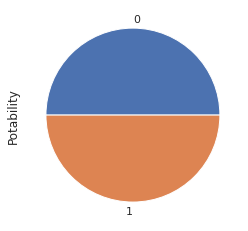

In [6]:
# Load dataset
df = pd.read_csv('water_potability.csv')
df = df[df['Potability'].notna()]


# Add extra samples of minority class (Potability=1)
df_upsampled = resample(df[df['Potability']==1], replace = True, 
                            n_samples = df.Potability.value_counts().max()-df.Potability.value_counts().min()) 

df = pd.concat([df, df_upsampled]) 
df = shuffle(df)

df.Potability.value_counts().plot(kind ='pie')
print(df.Potability.value_counts())

y = df['Potability']
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Potability'], axis=1),
    y,
    test_size=0.15,
    random_state=0,
    stratify=y
    )
    
print("X_train.shape, X_test.shape = ")
print(X_train.shape, X_test.shape)

print("% of Potability in original dataset: "+str((df['Potability']==1).sum()/df.shape[0]*100))
print("% of Potability in y_train: "+str((y_train==1).sum()/y_train.shape[0]*100))
print("% of Potability in y_test: "+str((y_test==1).sum()/y_test.shape[0]*100))

# Create df_train and df_test to process all columns together
df_train = X_train.copy()
df_train['Potability']=y_train

df_test = X_test.copy()
df_test['Potability']=y_test

In [7]:
def pre_process_df(df, test_mode=False, param_dict={}, scale=True):

    if test_mode and not param_dict:
        raise Exception('param_list need for test mode')

    df_ = df.copy()

    # Outliers
    norm_col = [
                'ph', 
                'Hardness', 
                'Solids', 
                'Chloramines',
                'Sulfate', 
                'Conductivity',
                'Organic_carbon', 
                'Trihalomethanes', 
                'Turbidity'
            ]

    if not test_mode:
        df_, outliers_limits_ = transform_outliers(df_, norm_col)
    else:
        df_ = transform_outliers(df_, norm_col, test_mode=test_mode, limits=param_dict['outliers_limits'])
    
    # Scaling - General
    scaled_columns = [
                'ph', 
                'Hardness', 
                'Solids', 
                'Chloramines',
                'Sulfate', 
                'Conductivity',
                'Organic_carbon', 
                'Trihalomethanes', 
                'Turbidity'
            ]
    if scale:
        if not test_mode:
            scaler_ = StandardScaler()
            scaler_.fit(df_[scaled_columns])
        else:
            scaler_ = param_dict['scaler']
            
        df_[scaled_columns] = scaler_.transform(df_[scaled_columns])
    else:
        if not test_mode:
            scaler_ = None

    # Imputation
    imputed_by_median_col = ['Trihalomethanes']           
    imputed_by_knn_col = ['ph','Sulfate']
    neighbors_col =['Hardness','Solids','Chloramines','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']

    if not test_mode:
        df_, median_imputer_list_ = median_imputer(df_,imputed_by_median_col)
        df_, knn_imputer_list_ = knn_imputer(df_, imputed_by_knn_col, neighbors_col)
    else:
        df_ = median_imputer(df_, imputed_by_median_col, test_mode=test_mode, imputer_trained=param_dict['median_imputer_list'])
        df_ = knn_imputer(df_, imputed_by_knn_col, neighbors_col, test_mode=test_mode, imputer_trained=param_dict['knn_imputer_list'])

    # Normalization
    norm_col_yj = [
        'Hardness',
        'Solids',
        'Chloramines',
        'Conductivity',
        'Organic_carbon',
        'Turbidity',
        'Trihalomethanes',
        'ph',
        'Sulfate'
    ]
    
    if not test_mode:
        power_yj_ = PowerTransformer(method= 'yeo-johnson')
        power_yj_.fit(df_[norm_col_yj])
    else:
        power_yj_ = param_dict['power_yj']
                
    df_[norm_col_yj] = power_yj_.transform(df_[norm_col_yj])

    if not test_mode:
        param_dict={'outliers_limits': outliers_limits_, 
                'scaler': scaler_, 
                'median_imputer_list': median_imputer_list_, 
                'knn_imputer_list': knn_imputer_list_, 
                'power_yj': power_yj_
        }
        return df_, param_dict

    return df_

In [8]:
df_train_processed, param_dict = pre_process_df(df_train)
df_test_processed = pre_process_df(df_test, test_mode=True, param_dict=param_dict)

df_train_processed_not_scaled, param_dict_not_scaled = pre_process_df(df_train, scale=False)
df_test_processed_not_scaled = pre_process_df(df_test, test_mode=True, param_dict=param_dict, scale=False)

## Save data into pickle file

In [9]:
# Scaled
df_train_processed.to_pickle('./data/df_train_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "wb")
pickle.dump(param_dict, open_file)
open_file.close()

df_test_processed.to_pickle('./data/df_test_processed.pkl')


# Not scaled
df_train_processed_not_scaled.to_pickle('./data/df_train_processed_not_scaled.pkl')

open_file = open('./data/df_param_dict_not_scaled.pkl', "wb")
pickle.dump(param_dict_not_scaled, open_file)
open_file.close()

df_test_processed_not_scaled.to_pickle('./data/df_test_processed_not_scaled.pkl')